# **Pneumonia identification from X-Ray Images**


---
By: Alejandro Bernabeu Durandez, Alberto González Calatayud and Enrique Solera Navarro

***Description***: This code develops machine learning models using Apache Spark to classify X-Ray images from a Pediatric Chest X-Ray Image dataset. The primary goal is to accurately predict Pneumonia in patients. To achieve this, the models are built utilizing the advanced pyspark interfaces combined with BigDL, which is a platform designed for creating scalable deep learning applications.


---




#Contents

1. Introduction
2. Material and Methods
3. Results
4. Discussion
5. Conclusion
6. References

<a id="1"></a>
##Introduction



Pneumonia, a respiratory infection affecting the lungs, continues to pose significant health challenges worldwide. Particularly concerning is its high mortality rate in intensive care units (ICUs). A study focusing on hospitalized patients with Community-Acquired Pneumonia (CAP) in the United States revealed that 23% required ICU admission. This group demonstrated considerable mortality rates, with figures ranging between 27-50% for short and long-term cases. The increased risk is more pronounced in older populations and those with serious comorbidities. Hospital-Acquired Pneumonia (HAP), including its subset Ventilator-Associated Pneumonia (VAP), also shows a high mortality rate, ranging up to 28% in cases involving mechanical ventilation [1].

In terms of risk factors for mortality among ICU patients with pneumonia, studies indicate that variables like higher APACHE II score on admission, chronic heart failure, and the need for interventions such as dialysis are significant predictors of mortality. A multicenter trial database analysis showed that around 17% of patients admitted to the ICU with pneumonia succumbed in the ICU, while 22% died in the hospital. These statistics underscore the critical need for effective treatment strategies and early intervention [2].

In this context, the proposed big data project aims to develop a supervised machine learning model to classify pediatric chest X-rays for the detection of pneumonia. This model could be a game-changer in healthcare, particularly in resource-limited settings where rapid diagnosis and treatment initiation are crucial but often challenging. By employing different approaches such as TensorFlow Keras, MLlib from PySpark, and DLlib from BigDL, the project seeks to harness the power of big data and advanced computing to make significant strides in pneumonia diagnosis and treatment.

This code was developed in Google Colab, and as such, it requires a google account to run the code and to mount the file directory of current use.

##Material and Methods

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -q pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from pyspark.sql import SparkSession
appname = 'Pneumonia identification from X-Ray images'
spark = SparkSession.builder.appName(appname).master("local[*]").getOrCreate()

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

#import tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

###Dataset import

This dataset is present in Kaggle, the source we will retrieve it with the following code.

(You need to download a `kaggle.json` file containing an authentification token to download the files programmatically accessing the Kaggle Public API. Instructions of how to do this are available at the [Kaggle website](https://www.kaggle.com/docs/api))

In [ ]:
#path to the kaggle.json directory
path_API_autentification_token= '/content/drive/MyDrive/kaggle'

In [ ]:
# Downloading the data to the Google Colab

import zipfile
import os

# Coping the kaggle API to the Google Colab
os.environ['KAGGLE_CONFIG_DIR'] = path_API_autentification_token

# Downloading the data
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzziping the data and storing into /tmp
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

100% 2.29G/2.29G [00:21<00:00, 179MB/s]
100% 2.29G/2.29G [00:21<00:00, 114MB/s]


###Data description

The dataset utilized in this project comprises pediatric chest X-ray images, originally compiled in a study by Kermany and colleagues (2018). This dataset has several notable features:

The images were collected from pediatric patients, specifically those between the ages of 1 and 5, at the Guangzhou Women and Children's Medical Center. The selection criteria included only Anterior-posterior X-rays that were part of standard medical procedures and met stringent quality control measures.

In terms of image analysis and categorization, each X-ray was meticulously examined and diagnosed by a pair of expert physicians, with a third specialist providing final approval, ensuring the accuracy of the diagnoses. These diagnoses were pivotal in determining patient care decisions, including urgent referrals for cases of bacterial pneumonia, supportive care for viral pneumonia cases, and observation for normal cases.

The dataset encompasses a total of 5,232 chest X-ray images, out of which 3,883 are pneumonia cases (with 2,538 bacterial and 1,345 viral) and 1,349 normal cases, sourced from 5,856 patients. This collection serves as the training material for the AI system. The dataset is structured into three primary folders – train, test, and val. Each folder contains two subfolders: NORMAL for images of patients without pneumonia, and PNEUMONIA for those with the condition, totaling 5,863 .jpeg images.

The dataset was pre-divided into training, testing, and validation subsets, sourced through the Kaggle API, eliminating the need for additional data splitting. The process involves importing the datasets directly into the work environment.

The steps to access the data involve fetching the file paths from the tmp directory where the dataset has been downloaded. This setup facilitates the streamlined integration of the dataset into the machine learning model development process.

In [ ]:
# Defining the paths of the directories that were unzipped
train_dir = '/tmp/chest_xray/train'
val_dir = '/tmp/chest_xray/val'
test_dir = '/tmp/chest_xray/test'


In the project, importing the chest X-ray images into dataframes will be efficiently executed using the `image_dataset_from_directory` function from the Keras preprocessing module. This function is specifically designed for handling image datasets and simplifies the process of loading and preprocessing the images for use in machine learning models.

The initial step in this process involves setting parameters for image height and width. This is crucial because the chest X-ray images in the dataset may vary in size, and for effective processing and analysis, they need to be resized to uniform dimensions. The consistent sizing ensures that the neural network receives input data in a standardized format, which is essential for accurate analysis and classification.

Additionally, the batch size will be defined. In machine learning, particularly in neural networks, the batch size refers to the number of samples that are processed through the network in one pass. Choosing the appropriate batch size is vital as it affects the model's learning process, memory usage, and computational efficiency. A well-chosen batch size helps in achieving a balance between learning speed and the stability of the learning process.

By utilizing the `image_dataset_from_directory` function with these parameters, the project ensures that the images are appropriately prepared for the subsequent steps of the machine learning pipeline. This includes the resizing of images for uniformity and batching for efficient processing, thereby laying a solid foundation for the development of a robust pneumonia detection model.

In [ ]:
#Define image sizes
img_height = 256
img_width = 256
batch_size = 32

To explore the distribution of instances across the datasets, a code segment can be written that counts and reports the number of images within each category (normal, pneumonia) in the training, validation, and test sets. This step is essential for understanding the label balance, which is crucial for the model's training phase.

In [ ]:
#import images into dataframes
train_df = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    color_mode = 'grayscale',
    image_size = (img_height,img_width),
    batch_size = batch_size
)

val_df = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    color_mode = 'grayscale',
    image_size = (img_height,img_width),
    batch_size = batch_size
)

test_df = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    color_mode = 'grayscale',
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
train_labels = []
test_labels = []
val_labels = []

for images, labels in train_df.unbatch():
  train_labels.append(labels.numpy())

for images, labels in test_df.unbatch():
  test_labels.append(labels.numpy())

for images, labels in val_df.unbatch():
  val_labels.append(labels.numpy())

In [ ]:
print("Count values of instances per label in train dataset\n")
print(pd.DataFrame(np.unique(train_labels, return_counts = True), index=['Label', 'count'], columns=['Normal','Pneumonia']))
print("\n\nCount values of instances per label in test dataset\n")
print(pd.DataFrame(np.unique(test_labels, return_counts = True), index=['Label', 'count'], columns=['Normal','Pneumonia']))
print("\n\nCount values of instances per label in validation dataset\n")
print(pd.DataFrame(np.unique(val_labels, return_counts = True), index=['Label', 'count'], columns=['Normal','Pneumonia']))

Count values of instances per label in train dataset

       Normal  Pneumonia
Label       0          1
count    1341       3875


Count values of instances per label in test dataset

       Normal  Pneumonia
Label       0          1
count     234        390


Count values of instances per label in validation dataset

       Normal  Pneumonia
Label       0          1
count       8          8


The identified imbalance in the distribution of images between normal patients and those with pneumonia in your dataset is a common challenge in machine learning, particularly in medical image analysis. When the number of instances in different classes varies significantly, it can lead to biases in the model. This is because the model may learn to preferentially recognize the class with more instances, potentially at the expense of accuracy in identifying less-represented classes.

In your case, the distribution of instances is as follows:



*   **Train dataset:** 5216 instances (89.0%)
*   **Test dataset:** 624 instances (10.7%)
*   **Validation dataset:** 16 instances (0.3%)
*   **Total:** 5856 instances

This distribution suggests a significant imbalance not only in terms of the class representation (normal vs. pneumonia) but also in the size of the datasets used for training, testing, and validation.

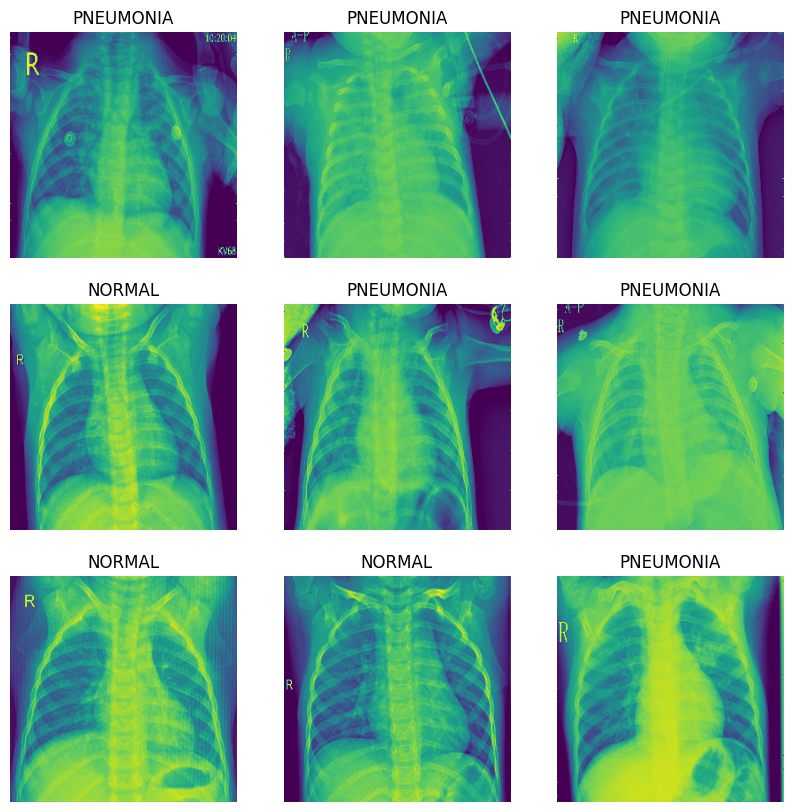

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
        plt.title(train_df.class_names[labels[i]])
        plt.axis("off")

##Results

### **CNN**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(20,20)

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Input,MaxPooling2D,Dropout,BatchNormalization

from sklearn.metrics import classification_report, confusion_matrix

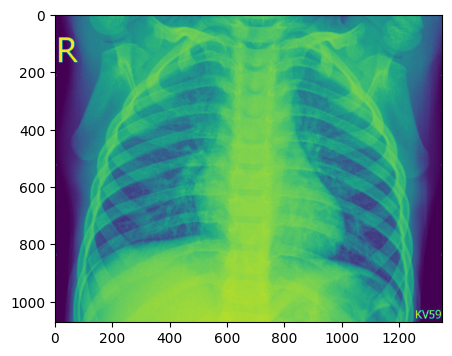

In [ ]:
from glob import glob
path_train = "/tmp/chest_xray/train"
img = glob(path_train+"/PNEUMONIA/*.jpeg")

img = np.asarray(plt.imread(img[0]))
plt.figure(figsize = (5 , 5))
plt.imshow(img)

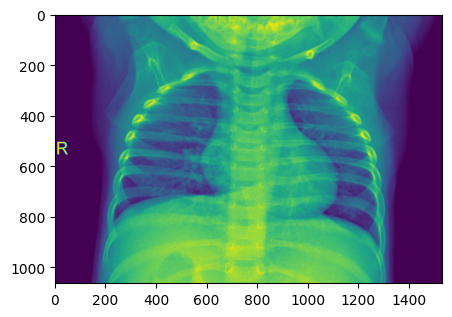

In [ ]:
img = glob(path_train+"/NORMAL/*.jpeg")
img = np.asarray(plt.imread(img[0]))
plt.figure(figsize = (5 , 5))
plt.imshow(img)

**Which data augmentation techniques will you employ that are appropriate for this problem?**

1. Horizontal Flip: This technique involves flipping both the rows and columns of a matrix horizontally.
2. Brightness Range: It increases the overall lightness of the image.
3. Height and Width Shift: This involves shifting the height and width of the image.
4. Image Rotation: We can rotate the image by any degree ranging from 0 to 360 degrees clockwise.










In [ ]:
img_size=150
batch_size=25

traingen=ImageDataGenerator(rescale=1/255.,
                           rotation_range=50,
                        brightness_range=[0.2,1.2],
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           horizontal_flip=True)


testgen=ImageDataGenerator(rescale=1/255.)

valgen=ImageDataGenerator(rescale=1/255.)

In [ ]:
traindata=traingen.flow_from_directory('/tmp/chest_xray/train',
                                       target_size=(img_size,img_size)
                                       ,batch_size=batch_size,
                                       shuffle=True,class_mode='binary'
                                      ,color_mode='grayscale')

testdata=testgen.flow_from_directory('/tmp/chest_xray/test',
                                    shuffle=False,batch_size=batch_size,
                                    target_size=(img_size,img_size),
                                    class_mode="binary",color_mode='grayscale')
valdata=valgen.flow_from_directory('/tmp/chest_xray/val',
                                    shuffle=False,batch_size=batch_size,
                                    target_size=(img_size,img_size),
                                    class_mode="binary",color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### MetaData

In [ ]:
df=pd.DataFrame(traindata.classes)
df.value_counts()

1    3875
0    1341
dtype: int64

In [ ]:
df=pd.DataFrame(valdata.classes)
df.value_counts()

0    8
1    8
dtype: int64

In [ ]:
df=pd.DataFrame(testdata.classes)
df.value_counts()

1    390
0    234
dtype: int64

### Creation of **CNN**

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

model=Sequential()
model.add(Conv2D(32,(2,2),input_shape=(img_size,img_size,1),activation="relu",padding='same',strides=1))
model.add(MaxPooling2D())
model.add(Conv2D(64,(2,2),strides=2,activation="relu",padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128,(2,2),strides=1,activation="relu",padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(1,activation='sigmoid'))

Explanation of the Model:



1.   Convolutional Layers: Three Conv2D layers are utilized, each with a specific number of filters (32, 64, 128). They utilize ReLU activation function and employ padding to maintain the spatial dimensions of the input.

2. MaxPooling Layers: These layers reduce the spatial dimensions of the feature maps, aiding in computational efficiency and extracting dominant features while reducing overfitting.

3. Flatten Layer: A Flatten layer is added to reshape the 2D arrays into a 1D array, preparing the data for input into the subsequent dense layers.

4. Dense Layers: Two Dense layers are incorporated. The first Dense layer consists of 128 units and uses the ReLU activation function. This layer facilitates the learning of complex patterns in the data. Additionally, a dropout layer is inserted after this dense layer to mitigate overfitting by randomly deactivating a fraction of neurons during training.

5. Output Layer: The final Dense layer contains a single unit with a sigmoid activation function, indicating its suitability for binary classification.



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 9, 9, 128)         0

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
filepath= "model_cnn.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)

### Training of **CNN**

In [ ]:
history=model.fit(traindata,validation_data=valdata,epochs=15,callbacks=[checkpoint])

Epoch 1/15
209/209 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.7538
Epoch 1: val_loss improved from inf to 0.61659, saving model to model_cnn.h5
209/209 [==============================] - 56s 244ms/step - loss: 0.5081 - accuracy: 0.7538 - val_loss: 0.6166 - val_accuracy: 0.8125
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


209/209 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.8493
Epoch 2: val_loss did not improve from 0.61659
209/209 [==============================] - 45s 217ms/step - loss: 0.3227 - accuracy: 0.8493 - val_loss: 0.8439 - val_accuracy: 0.7500
Epoch 3/15
209/209 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.8842
Epoch 3: val_loss did not improve from 0.61659
209/209 [==============================] - 45s 216ms/step - loss: 0.2637 - accuracy: 0.8842 - val_loss: 0.7156 - val_accuracy: 0.8125
Epoch 4/15
209/209 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.8888
Epoch 4: val_loss did not improve from 0.61659
209/209 [==============================] - 43s 207ms/step - loss: 0.2569 - accuracy: 0.8888 - val_loss: 0.6196 - val_accuracy: 0.8750
Epoch 5/15
209/209 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.8963
Epoch 5: val_loss improved from 0.61659 to 0.54957, saving model to model_cnn.h5
209

### **Loss** and **Accuracy** Curves from training and validation

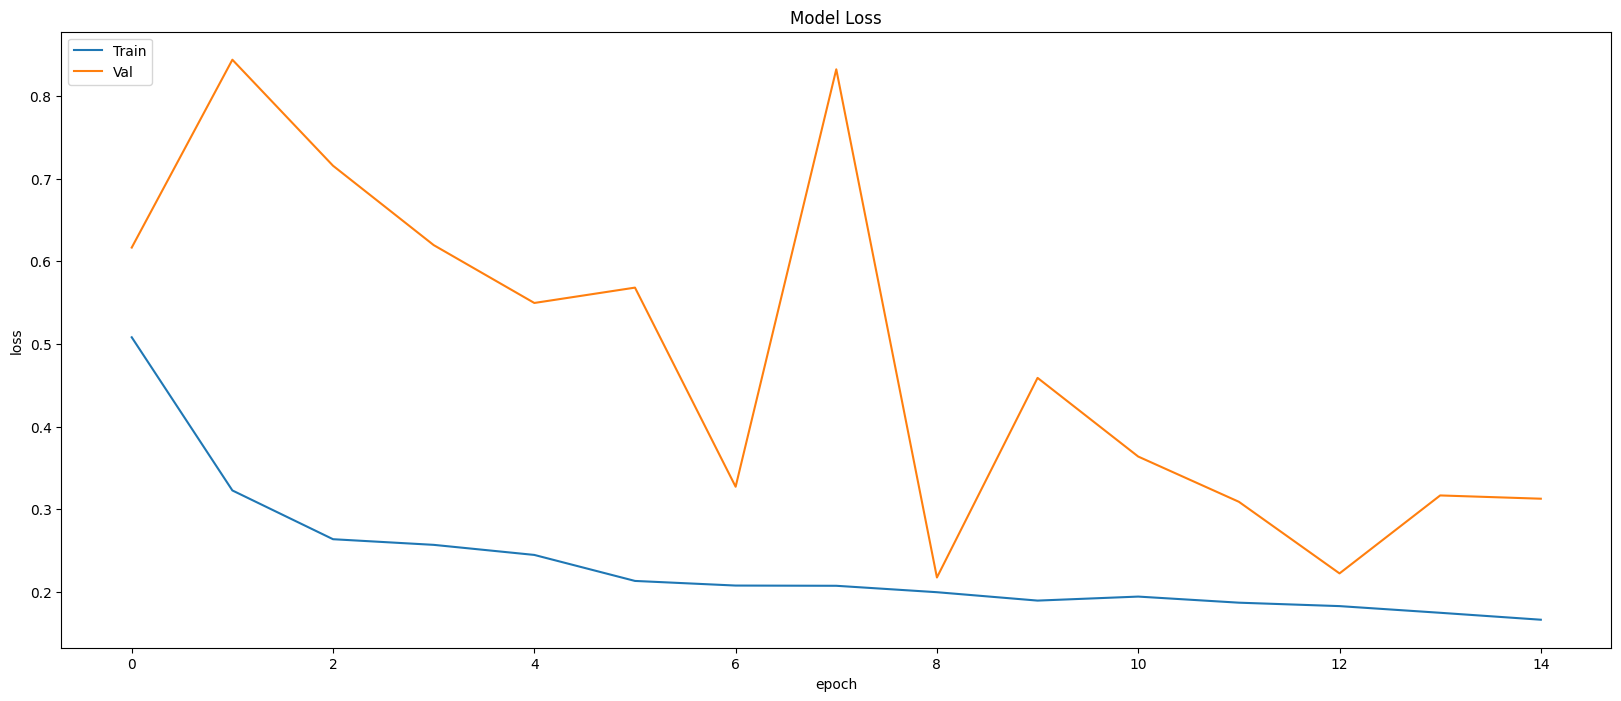

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

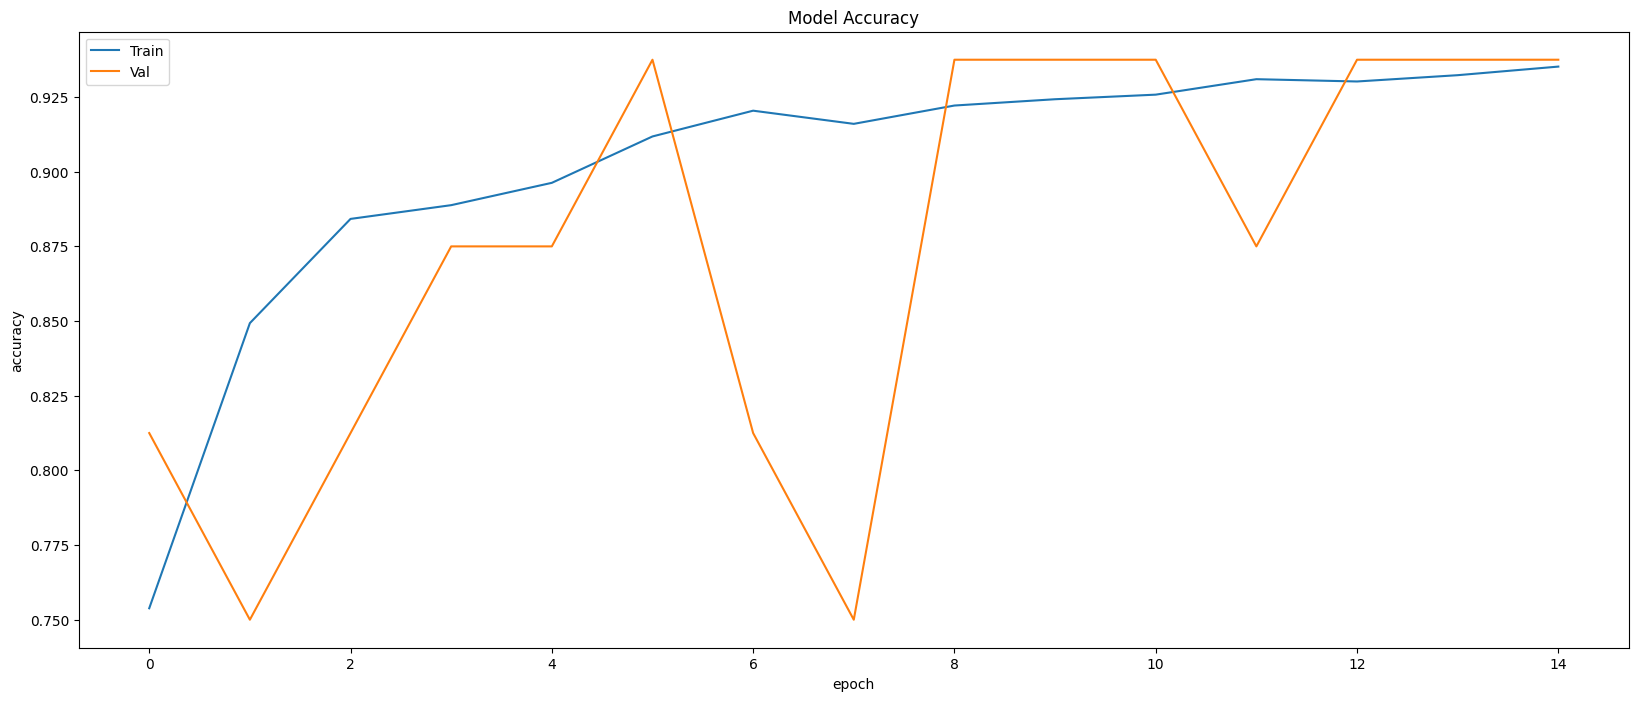

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Verifying Model Predictions for **Validation Data**

In [ ]:
y_test = valdata.classes
y_pred = model.predict(valdata)
y_pred_probs = y_pred.copy()
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

1/1 [==============================] - 0s 183ms/step


In [ ]:
print(classification_report(y_test,y_pred,target_names = ['Normal','Pnuemonia']))

              precision    recall  f1-score   support

      Normal       1.00      0.88      0.93         8
   Pnuemonia       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



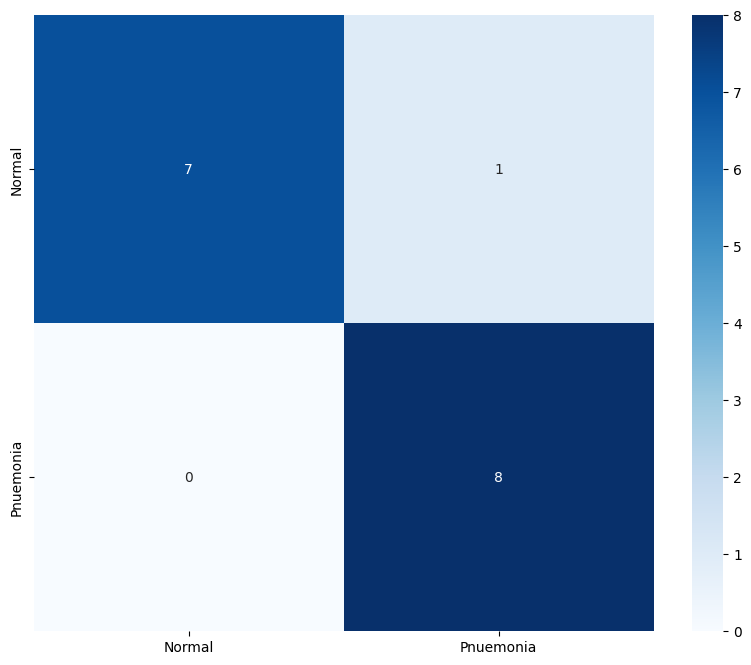

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=['Normal','Pnuemonia'],
            yticklabels=['Normal','Pnuemonia'],cmap='Blues')
plt.show()

### Evaluating Model Predictions for **Test Data**

In [ ]:
y_test = testdata.classes
y_pred = model.predict(testdata)
y_pred_probs = y_pred.copy()

25/25 [==============================] - 3s 107ms/step


In [ ]:
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,y_pred,target_names = ['Normal','Pnuemonia']))

              precision    recall  f1-score   support

      Normal       0.92      0.68      0.78       234
   Pnuemonia       0.84      0.96      0.90       390

    accuracy                           0.86       624
   macro avg       0.88      0.82      0.84       624
weighted avg       0.87      0.86      0.85       624



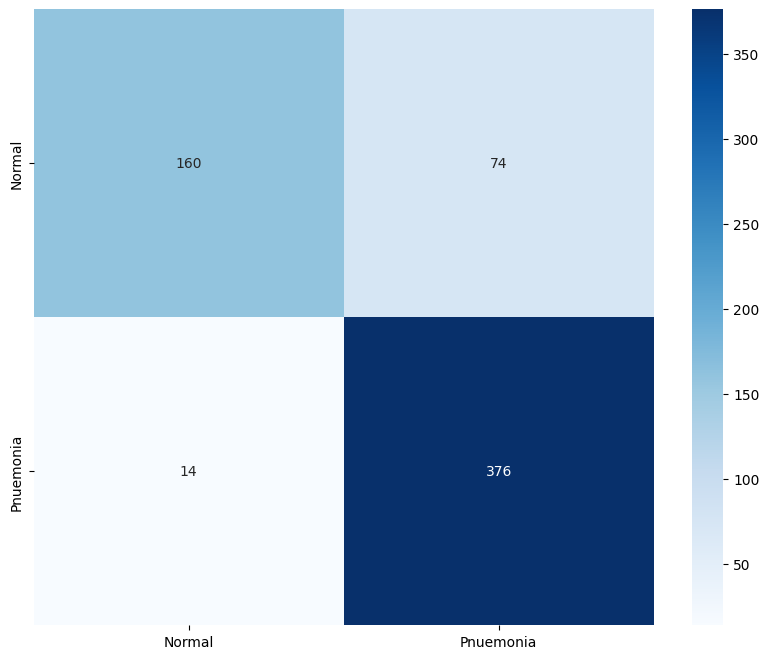

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=['Normal','Pnuemonia'],
            yticklabels=['Normal','Pnuemonia'],cmap='Blues')
plt.show()

### Model Experimentation

In [ ]:
filenames = testdata.filenames
data = pd.DataFrame()
data['filename'] = filenames
data['actual_class'] = y_test
data['predicted_class'] = y_pred
data['predicted_prob'] = y_pred_probs

In [ ]:
misclassification = data[data['actual_class']!=data['predicted_class']]

In [ ]:
misclassification[(misclassification['actual_class']==0) & (misclassification['predicted_prob']>0.9)]

,filename,actual_class,predicted_class,predicted_prob
3,NORMAL/IM-0006-0001.jpeg,0,1.0,0.961530
16,NORMAL/IM-0022-0001.jpeg,0,1.0,0.947659
20,NORMAL/IM-0028-0001.jpeg,0,1.0,0.987357
26,NORMAL/IM-0033-0001.jpeg,0,1.0,0.984178
44,NORMAL/IM-0071-0001.jpeg,0,1.0,0.914442
47,NORMAL/IM-0077-0001.jpeg,0,1.0,1.000000
49,NORMAL/IM-0081-0001.jpeg,0,1.0,0.982900
119,NORMAL/NORMAL2-IM-0195-0001.jpeg,0,1.0,0.998928
121,NORMAL/NORMAL2-IM-0198-0001.jpeg,0,1.0,0.999887
122,NORMAL/NORMAL2-IM-0199-0001.jpeg,0,1.0,0.991335


### **BigDL**

#### Import BigDL DLlib from Analytics Zoo

In [ ]:
# Install latest pre-release version of bigdl-dllib with spark3
# Find the latest bigdl-dllib with spark3 from https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/ and intall it
!pip install https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/bigdl_dllib_spark3-0.14.0b20211107-py3-none-manylinux1_x86_64.whl

# exit() # restart the runtime to refresh installed pkg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 22.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880747 sha256=3f67f39630ff12a30d35c7a26462c8bb6c5c79d49431e02b879c1d6827a174c3
  Stored in directory: /root/.cache/pip/wheels/ef/70/50/7882e1bcb5693225f7cc86698f10953201b48b3f36317c2d18
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.0
    Uninstalling pyspark-3.5.0:
      Successfully uninstalled pyspark-3.5.0


In [ ]:
!pip install findspark

In [ ]:
from bigdl.dllib.nn.layer import *
from bigdl.dllib.nn.criterion import *
from bigdl.dllib.optim.optimizer import *
from bigdl.dllib.nncontext import *
from bigdl.dllib import keras
from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.models import *
from bigdl.dllib.nnframes import *
from bigdl.dllib.nn.criterion import *

from pyspark import SparkContext
from pyspark.sql import SparkSession
from IPython.display import Markdown, display

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, LeakyReLU
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing import image

Prepending /usr/local/lib/python3.10/dist-packages/bigdl/share/dllib/conf/spark-bigdl.conf to sys.path


In [ ]:
sc = init_nncontext(cluster_mode="local") # run in local mode
spark = SparkSession(sc)

Current pyspark location is : /usr/local/lib/python3.10/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.10/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_3.1.2-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


In [ ]:
import findspark
findspark.init()

In [ ]:
batch_size = 32

#data transformation
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)

#import the data
train_generator= train_datagen.flow_from_directory(train_dir, target_size =(64,64), batch_size = 64, class_mode="binary" )
validation_generator = validation_datagen.flow_from_directory(val_dir, target_size = (64,64), batch_size =  batch_size, class_mode="binary")
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (64,64), batch_size= batch_size,  class_mode="binary")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
X_train, Y_train = next(train_generator)
X_val, Y_val = next(validation_generator)
X_test, Y_test = next(test_generator)

Explanation of the model used:

1. Reshape Layer: It reshapes the input data to (3, 64, 64) from (64, 64, 3). This is a necessary preprocessing step as BigDL processes images in a different format compared to other frameworks like TensorFlow or PyTorch. The original format is height x width x channels, but BigDL uses channels x height x width.

2. Convolution2D Layers: These layers create a convolution kernel that convolves with the layer input to produce a tensor of outputs. The model uses three such layers with increasing numbers of filters (32, 64, 128). Convolution layers are fundamental in CNNs and help the model to learn features from the images.

3. MaxPooling2D Layers: These layers follow each convolution layer and perform downsampling operations, reducing the dimensionality of the input, which helps to reduce the computation and to extract dominant features, while reducing overfitting.

4. Flatten Layer: After several convolutional and pooling layers, this layer flattens the 2D arrays to a 1D array to prepare the data for input into the dense layers.

5. Dense Layers: These are fully connected layers. The first dense layer has 256 units and uses the ReLU activation function. It's followed by a dropout layer, which helps in preventing overfitting by randomly setting a fraction of input units to 0 at each update during training.

6. Output Layer: The last dense layer has 1 unit with a sigmoid activation function, indicating that this model is intended for binary classification (such as normal vs. pneumonia).

7. Compile the Model: The model uses the Adam optimizer and Binary Cross-Entropy as the loss function, which is typical for binary classification tasks. The accuracy metric is used to evaluate the model's performance.

In [ ]:
from bigdl.dllib.keras.layers import Reshape, Convolution2D, MaxPooling2D, Dense, Flatten, Dropout, BinaryCrossEntropy
from bigdl.dllib.keras.models import Sequential
from bigdl.dllib.keras.optimizers import Adam

model = Sequential()
model.add(Reshape((3, 64, 64), input_shape=(64, 64, 3)))
model.add(Convolution2D(32, 3, 3, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(128, 3, 3, activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))   # Assuming binary classification

model.compile(optimizer=Adam(), loss=BinaryCrossEntropy(), metrics=['accuracy'])


creating: createZooKerasSequential
creating: createZooKerasReshape
creating: createZooKerasConvolution2D
creating: createZooKerasMaxPooling2D
creating: createZooKerasConvolution2D
creating: createZooKerasMaxPooling2D
creating: createZooKerasConvolution2D
creating: createZooKerasMaxPooling2D
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasDropout
creating: createZooKerasDense
creating: createZooKerasAdam
creating: createDefault
creating: createZooKerasBinaryCrossEntropy
creating: createZooKerasBinaryAccuracy


In [ ]:
model.fit(
        X_train,Y_train,
        nb_epoch=30,
        batch_size = 50,
        validation_data=(X_val, Y_val))

In [ ]:
accuracy = model.evaluate(X_test, Y_test, batch_size=20)
print("Loss: ", accuracy[0])
print("Accuracy: ", accuracy[1])

Loss:  0.5036487579345703
Accuracy:  0.875


In [ ]:
from sklearn.metrics import f1_score

# Predict on test data and collect the predictions
y_pred_rdd = model.predict(X_test)
y_pred_collected = y_pred_rdd.collect()

# Convert predictions and actuals to binary labels
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred_collected]
y_test_binary = [1 if x > 0.5 else 0 for x in Y_test]

# Calculate F1 Score
f1 = f1_score(y_test_binary, y_pred_binary)

print("F1 Score: ", f1)

F1 Score:  0.92


##Discussion

Pneumonia is a serious respiratory disease that can have devastating consequences if not detected and treated in time. Therefore, accuracy in the identification of this disease is of vital importance.

*Model Comparison:*

We have implemented two models to address this problem: one using TensorFlow and one using BigDL. In the following, we will discuss the results obtained by both models and analyze their strengths and weaknesses.

*CNN model with TensorFlow:*

The Convolutional Neural Networks (CNN) based model built with TensorFlow demonstrated robust performance on the training and validation set, with an overall accuracy of 94%. In particular, the model showed a high ability to identify pneumonia cases (100% recall), which is crucial for detecting the disease effectively. However, in the test set, the performance decreased, with an overall accuracy of 86%. Accuracy and recall for normal cases were noticeably lower in the test set, which could indicate a certain lack of generalization.

*Model with BigDL:*

The model implemented with BigDL also achieved impressive results, with a loss of 0.5036 and an accuracy of 87.5%. The F1-Score value achieved was 0.92, suggesting a solid ability to balance accuracy and recall. These results are promising and show that BigDL is a valuable tool to address disease identification tasks from medical images.

*General Comparison:*

Comparing both models, we can highlight some key differences. The TensorFlow model demonstrated exceptional ability to identify pneumonia cases in the training set, but its performance decreased in the test set. This could be due to possible overfitting in the TensorFlow model. In contrast, the model with BigDL showed robust generalization ability and balanced performance on the test set.

##Conclusion

In summary, both models have proven effective in identifying pneumonia from X-ray images, but each has its own strengths and weaknesses. The TensorFlow model could benefit from further regularization to improve its generalizability. On the other hand, the BigDL model shows great potential and could be a preferred choice for medical disease identification tasks in imaging.

##References

1. Cillóniz C, Torres A, Niederman M S. Management of pneumonia in critically ill patients BMJ 2021; 375 :e065871 doi:10.1136/bmj-2021-065871
2. Li, G., Cook, D.J., Thabane, L. et al. Risk factors for mortality in patients admitted to intensive care units with pneumonia. Respir Res 17, 80 (2016). https://doi.org/10.1186/s12931-016-0397-5
3. Intel Corporation. (2023). BigDL [Software]. Disponible en https://bigdl-project.github.io/
4. The TensorFlow Authors. (2023). TensorFlow [Software]. Disponible en https://www.tensorflow.org/
5. Apache Software Foundation. (2023). Apache Spark [Software]. Disponible en https://spark.apache.org/